# CMIP6 vs ERA5 Features

Objective:
- Compare the same features with data from different models, e.g. historical CMIP (MPI-M model) vs ERA5 reanalysis. 

In [1]:
import os
import sys
import xarray as xr
import dask
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())

folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)
from IndexDrivers import (
    AnomaliesIndex,
    MaxIndex, 
    calculate_anomalies
)
from PredictorsDrivers import (
    Predictor
)

c:\Users\marti\Desktop\data\hw_extra


In [3]:
ua = xr.open_mfdataset("data/MPI-ESM1-2-HR/historical/Amon/ua/*.nc", combine="by_coords", chunks={"time": 24}).sel(time=slice("1971-01", "2014-12"))
ta = xr.open_mfdataset("data/MPI-ESM1-2-HR/historical/Amon/ta/*.nc", combine="by_coords", chunks={"time": 24}).sel(time=slice("1971-01", "2014-12"))
psl = xr.open_mfdataset("data/MPI-ESM1-2-HR/historical/Amon/psl/*.nc", combine="by_coords", chunks={"time": 24}).sel(time=slice("1971-01", "2014-12"))
tos = xr.open_mfdataset("data/MPI-ESM1-2-HR/historical/Omon/tos/*.nc", combine="by_coords", chunks={"time": 24}).sel(time=slice("1971-01","2014-12"))

In [4]:
data_850 = xr.load_dataset("data/local_data/3means_850hpa_east_pacific.nc")
data_single = xr.load_dataset("data/local_data/7means_east_pacific.nc")
data_msl = xr.load_dataset("data/local_data/MSLP_east_pacific.nc")

In [5]:
ref_period = [1980,2010]

## Data processing

In [6]:
ua = ua.rename({
    "lat": "latitude",
    "lon": "longitude"
})
ta = ta.rename({
    "lat": "latitude",
    "lon": "longitude"
})
psl = psl.rename({
    "lat": "latitude",
    "lon": "longitude"
})

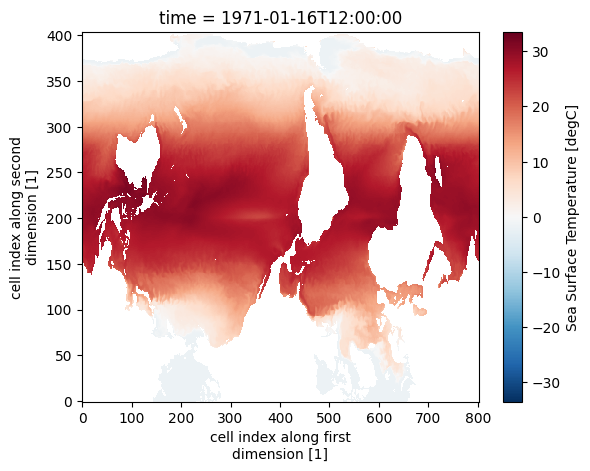

In [7]:
tos.isel(time=0).tos.plot()

In [8]:

from scipy.spatial import cKDTree

# === Load data ===
tos = xr.open_mfdataset("data/MPI-ESM1-2-HR/historical/Omon/tos/*.nc", combine="by_coords", chunks={"time": 24}).sel(time=slice("1971-01","2014-12"))

ds = tos
tos = ds["tos"]  # (time, j, i)
lat2d = ds["latitude"].values
lon2d = ds["longitude"].values
time = ds["time"]

# === Flatten source grid and build KDTree ===
source_points = np.column_stack((lat2d.ravel(), lon2d.ravel()))
tree = cKDTree(source_points)

# === Create regular grid ===
lat_new = np.arange(-90, 90.5, 0.5)
lon_new = np.arange(0, 360, 0.5)
lon_grid, lat_grid = np.meshgrid(lon_new, lat_new)
target_points = np.column_stack((lat_grid.ravel(), lon_grid.ravel()))

# === Map target points to nearest source points ===
_, idx = tree.query(target_points)
j_src, i_src = np.unravel_index(idx, lat2d.shape)

# === Use broadcasting to grab all times in one shot ===
tos_values = tos.values + 273  # shape (time, j, i) + to Kelvin
tos_interp = tos_values[:, j_src, i_src]  # shape (time, n_points)
tos_interp = tos_interp.reshape(len(time), len(lat_new), len(lon_new))

# === Build xarray Dataset ===
tos_da = xr.DataArray(
    tos_interp,
    dims=("time", "latitude", "longitude"),
    coords={
        "time": time,
        "latitude": lat_new,
        "longitude": lon_new,
    },
    name="tos"
)
tos_da.attrs = ds["tos"].attrs

ds_out = xr.Dataset({"tos": tos_da})
ds_out.attrs = ds.attrs

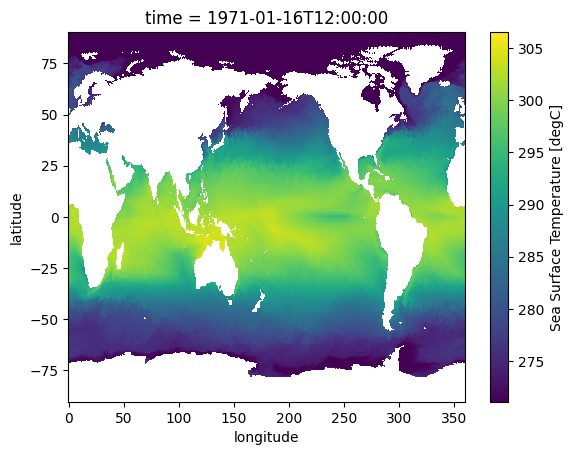

In [9]:
ds_out.isel(time=0).tos.plot()

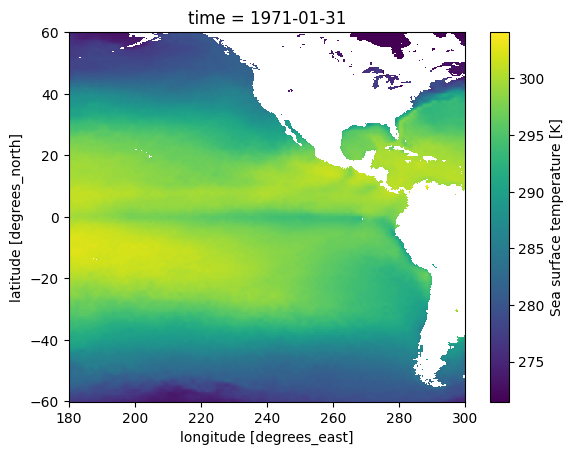

In [10]:
data_single.sst.isel(time=0).plot()

## Enso indices

In [11]:
boxes_pacific = {
    "niño3.4": [190, 240, -5, 5],  # [lon_min, lon_max, lat_min, lat_max]
    "niño1+2": [270, 280, -10, 0],
    "ocean_pressure": [260, 284, -44, -17], #study max over time and define region
    "chile" : [286, 288, -42, -33]
    #"advección": [280, 285, -37, -30]
}

In [12]:
nino34_cmip6 = AnomaliesIndex(ds_out, [1972,2022], reference_period=ref_period, variables=["tos"], box_limit=boxes_pacific["niño3.4"], rolling_window=1, frequency="monthly")
nino12_cmip6 = AnomaliesIndex(ds_out, [1972,2022], reference_period=ref_period, variables=["tos"], box_limit=boxes_pacific["niño1+2"], rolling_window=1, frequency="monthly")

nino34_era5 = AnomaliesIndex(data_single, [1972,2022], reference_period=ref_period, variables=["SST"], box_limit=boxes_pacific["niño3.4"], rolling_window=1, frequency="monthly")
nino12_era5 = AnomaliesIndex(data_single, [1972,2022], reference_period=ref_period, variables=["SST"], box_limit=boxes_pacific["niño1+2"], rolling_window=1, frequency="monthly")


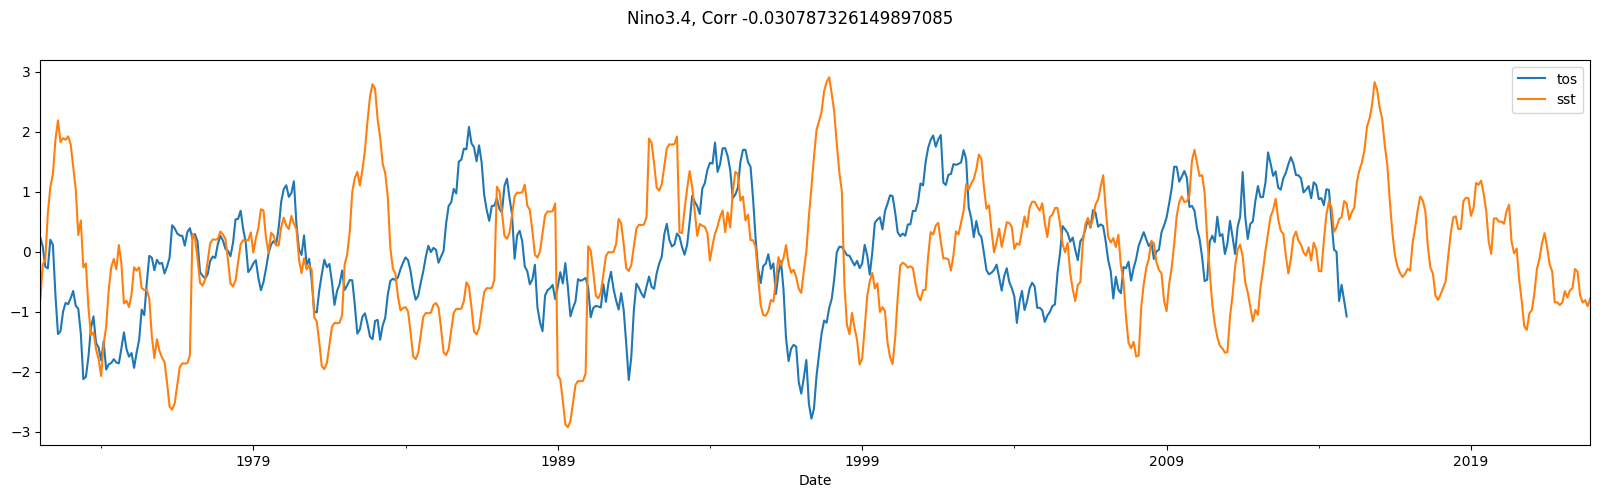

In [14]:
fig, ax = plt.subplots(1, figsize=(20,5))
nino34_cmip6.get_index("tos").plot(ax=ax)
nino34_era5.get_index("SST").plot(ax=ax)
corr = np.corrcoef(nino34_cmip6.get_index("tos")["tos"], nino34_era5.get_index("SST", end_year=2014)["sst"])[0,1]
fig.suptitle(f"Nino3.4, Corr {corr}")
plt.show()

Historical models reproduces well the mean variability of the ocean, but failes to reproduce the Niño events, such as 1997 and 1983. This is mainly because cmip6 model fail to reproduce the dates of events, but rather their frequency and amplitude, which is observable here.

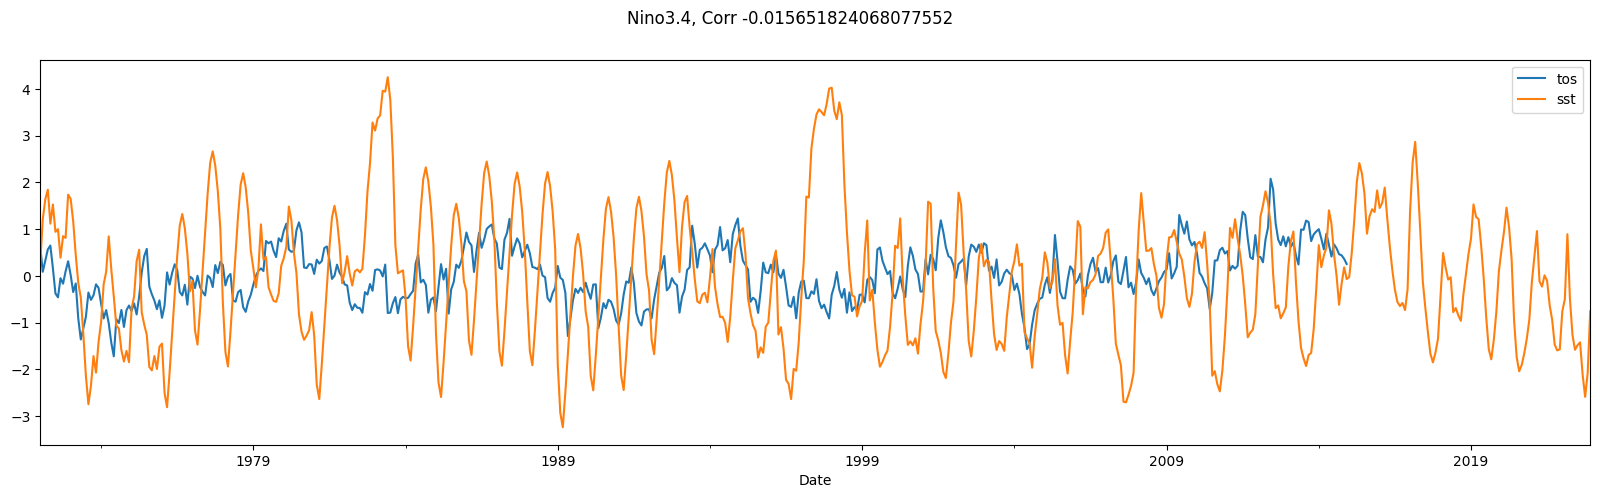

In [15]:
fig, ax = plt.subplots(1, figsize=(20,5))
nino12_cmip6.get_index("tos").plot(ax=ax)
nino12_era5.get_index("SST").plot(ax=ax)
corr = np.corrcoef(nino12_cmip6.get_index("tos")["tos"], nino12_era5.get_index("SST", end_year=2014)["sst"])[0,1]
fig.suptitle(f"Nino3.4, Corr {corr}")
plt.show()

Note the high variability of niño 1.2. Historical model variability is stabler. They hardly match on the pattern nor the peaks.

## Ocean anticyclone

In [34]:
ocean_cyclone_era5 = MaxIndex(data_msl, [1972,2022], variables=["MSL"], box_limit=boxes_pacific["ocean_pressure"], anomalies=True, climatology_period=ref_period)
ocean_cyclone_cmip6 = MaxIndex(psl, [1972,2022], variables=["psl"], box_limit=boxes_pacific["ocean_pressure"], anomalies=True, climatology_period=ref_period)


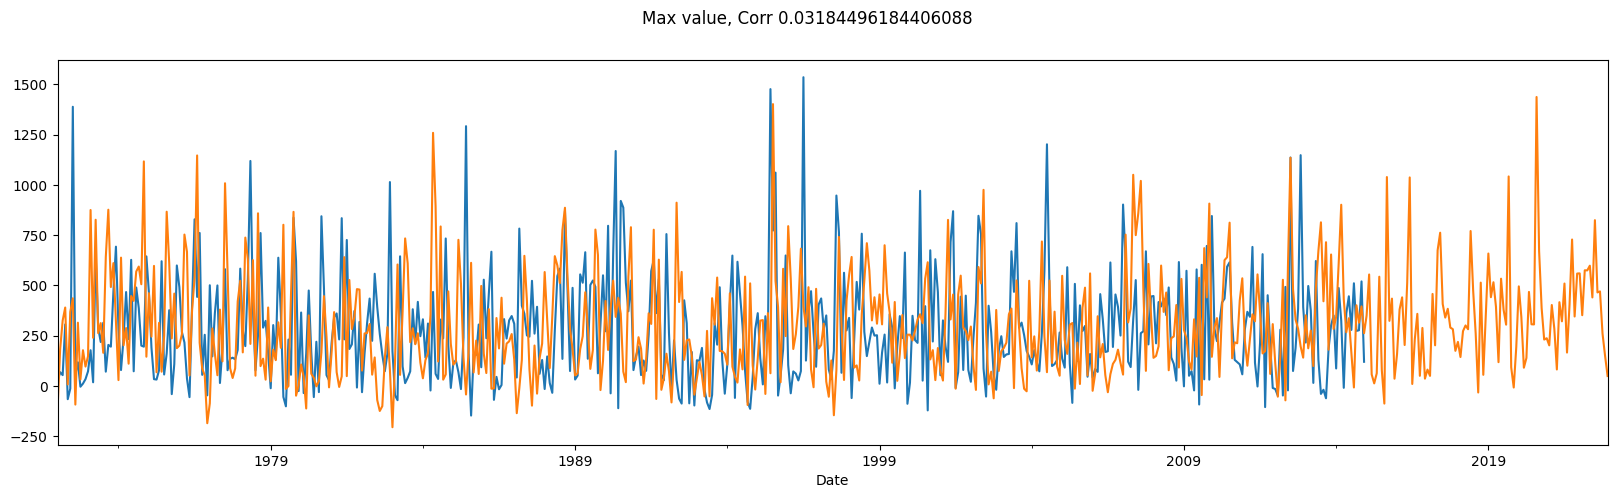

In [17]:
fig, ax = plt.subplots(1, figsize=(20,5))
ocean_cyclone_cmip6.get_index("psl")["max_value"].plot(ax=ax)
ocean_cyclone_era5.get_index("MSL")["max_value"].plot(ax=ax)
corr = np.corrcoef(ocean_cyclone_cmip6.get_index("psl")["max_value"], ocean_cyclone_era5.get_index("MSL", end_year=2014)["max_value"])[0,1]
fig.suptitle(f"Max value, Corr {corr}")
plt.show()

Here we can see more matching on the values, there are several peaks and valleys recognized by both models. Prolly works better than other indices because the box is big enough to neglate the resolution component?

## Vaguada Index

In [18]:
boxes_chile_vaguada = {
    "b": [286, 288.5, -33, -28],
    "A_cl": [280, 286, -38,-30], #test bigger A boxes
    "A_arg": [291, 295, -38, -30]
}

In [19]:
mslp_indices_era5 = [AnomaliesIndex(data_msl, [1972,2022], reference_period=ref_period, variables=["MSL"], box_limit=box, rolling_window=1, frequency="monthly") for key,box in boxes_chile_vaguada.items()]
mslp_indices_cmip6 = [AnomaliesIndex(psl, [1972,2022], reference_period=ref_period, variables=["psl"], box_limit=box, rolling_window=1, frequency="monthly") for key,box in boxes_chile_vaguada.items()]

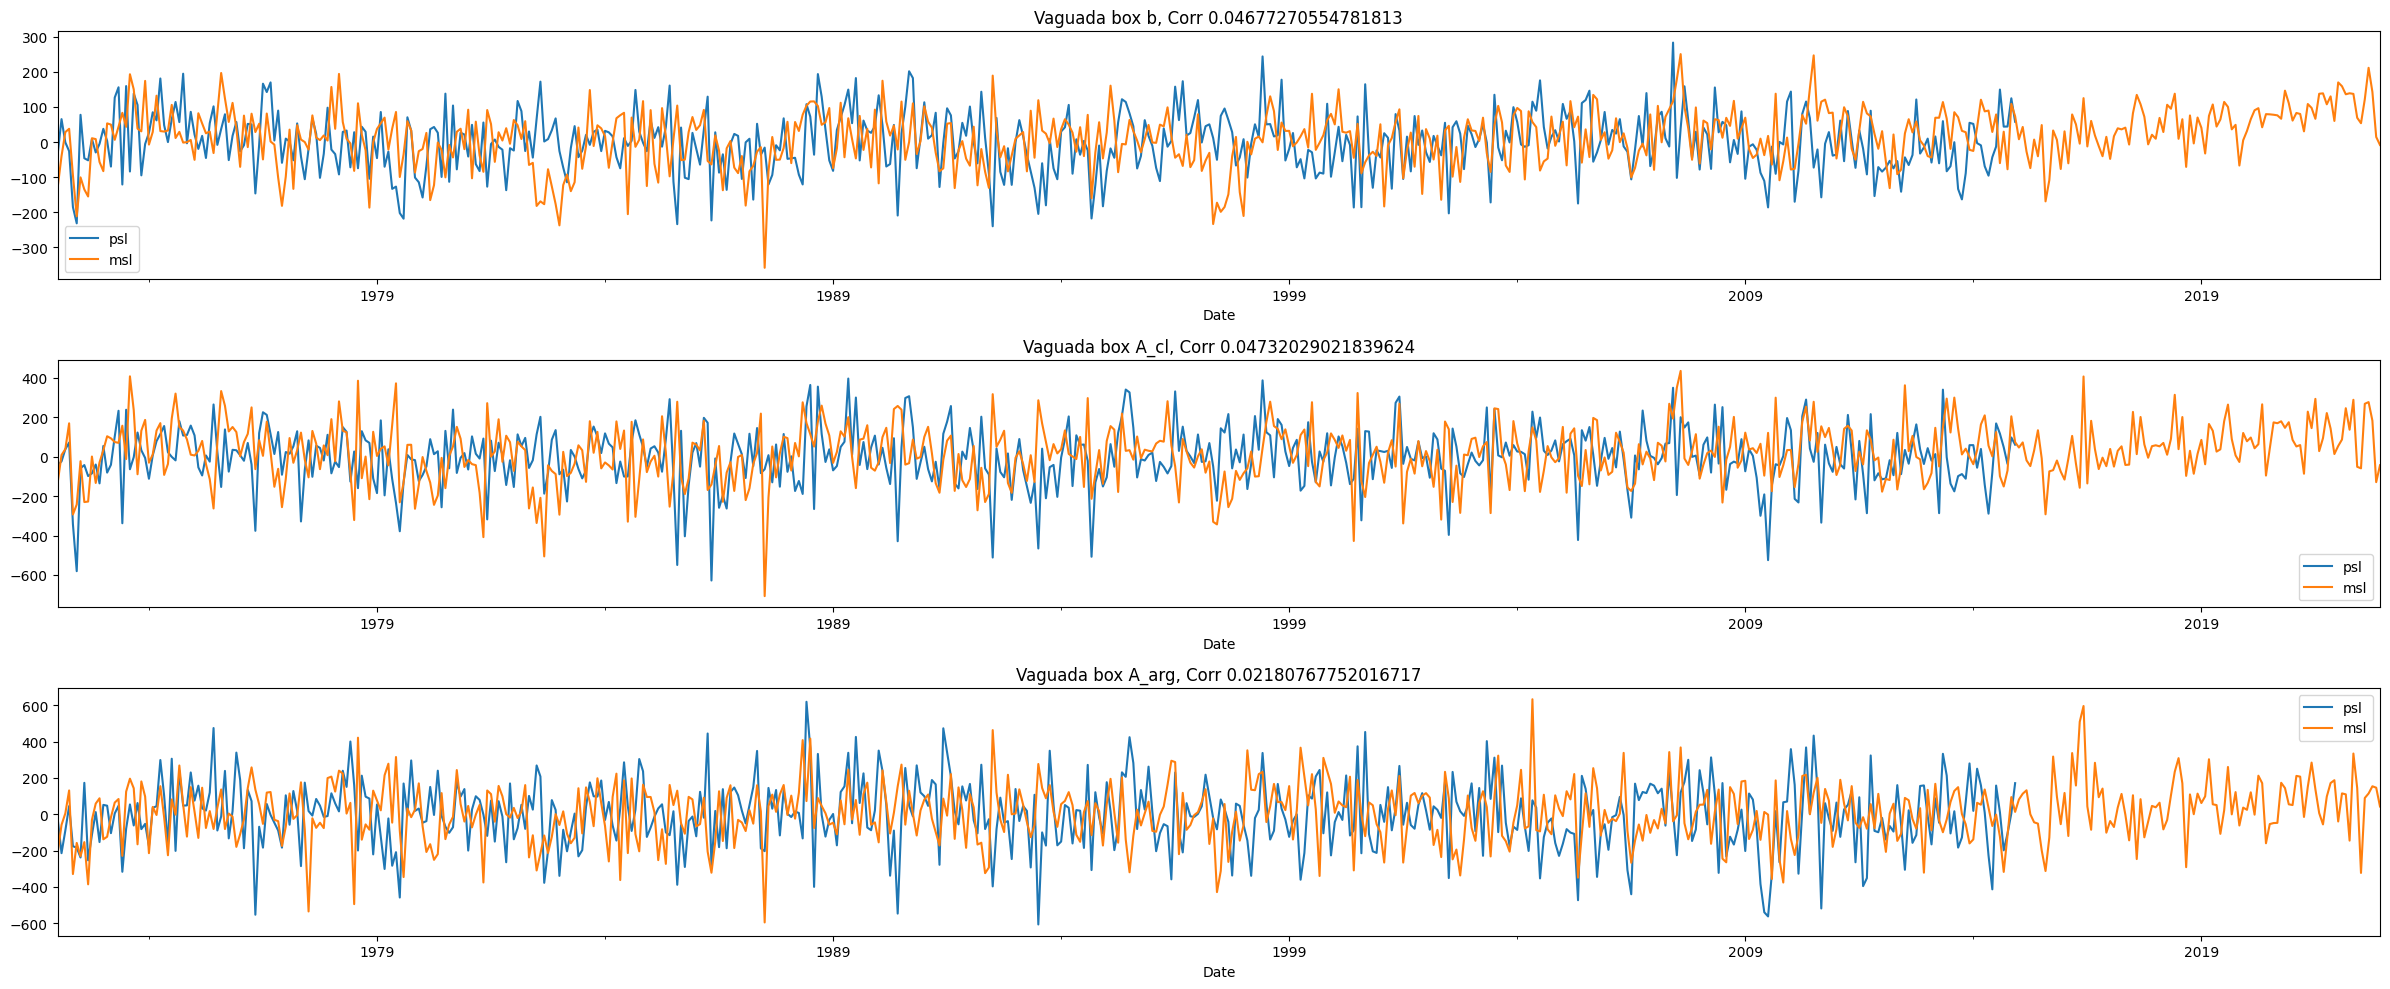

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(24,10))
for i in range(3):
    mslp_indices_cmip6[i].get_index("psl").plot(ax=axs[i])
    mslp_indices_era5[i].get_index("MSL").plot(ax=axs[i])
    corr = np.corrcoef(mslp_indices_cmip6[i].get_index("psl")["psl"], mslp_indices_era5[i].get_index("MSL", end_year=2014)["msl"])[0,1]
    axs[i].set_title(f"Vaguada box {list(boxes_chile_vaguada.keys())[i]}, Corr {corr}")
fig.tight_layout()
plt.show()

Vaguada looks good (specially from 2000), the three boxes patterns/variability are recognized by both models.

## Advection Index

In [21]:
adv_850 = -1*ua.sel(plev=85000).ua*ta.sel(plev=85000).ta
data_850["adv"] = -1*data_850.u*data_850.t
adv_850 = xr.Dataset({"adv": adv_850})


In [22]:
boxes_chile_adv = {
    "advection_chile": [282, 286, -42, -33],
    "advection_blob": [268, 283, -32, -20]
}

In [23]:
advection_indices_cmip6 = [AnomaliesIndex(adv_850, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection_chile"], rolling_window=1),
                     AnomaliesIndex(adv_850, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection_blob"], rolling_window=1)]
advection_indices_era5 = [AnomaliesIndex(data_850, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection_chile"], rolling_window=1),
                     AnomaliesIndex(data_850, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection_blob"], rolling_window=1)]

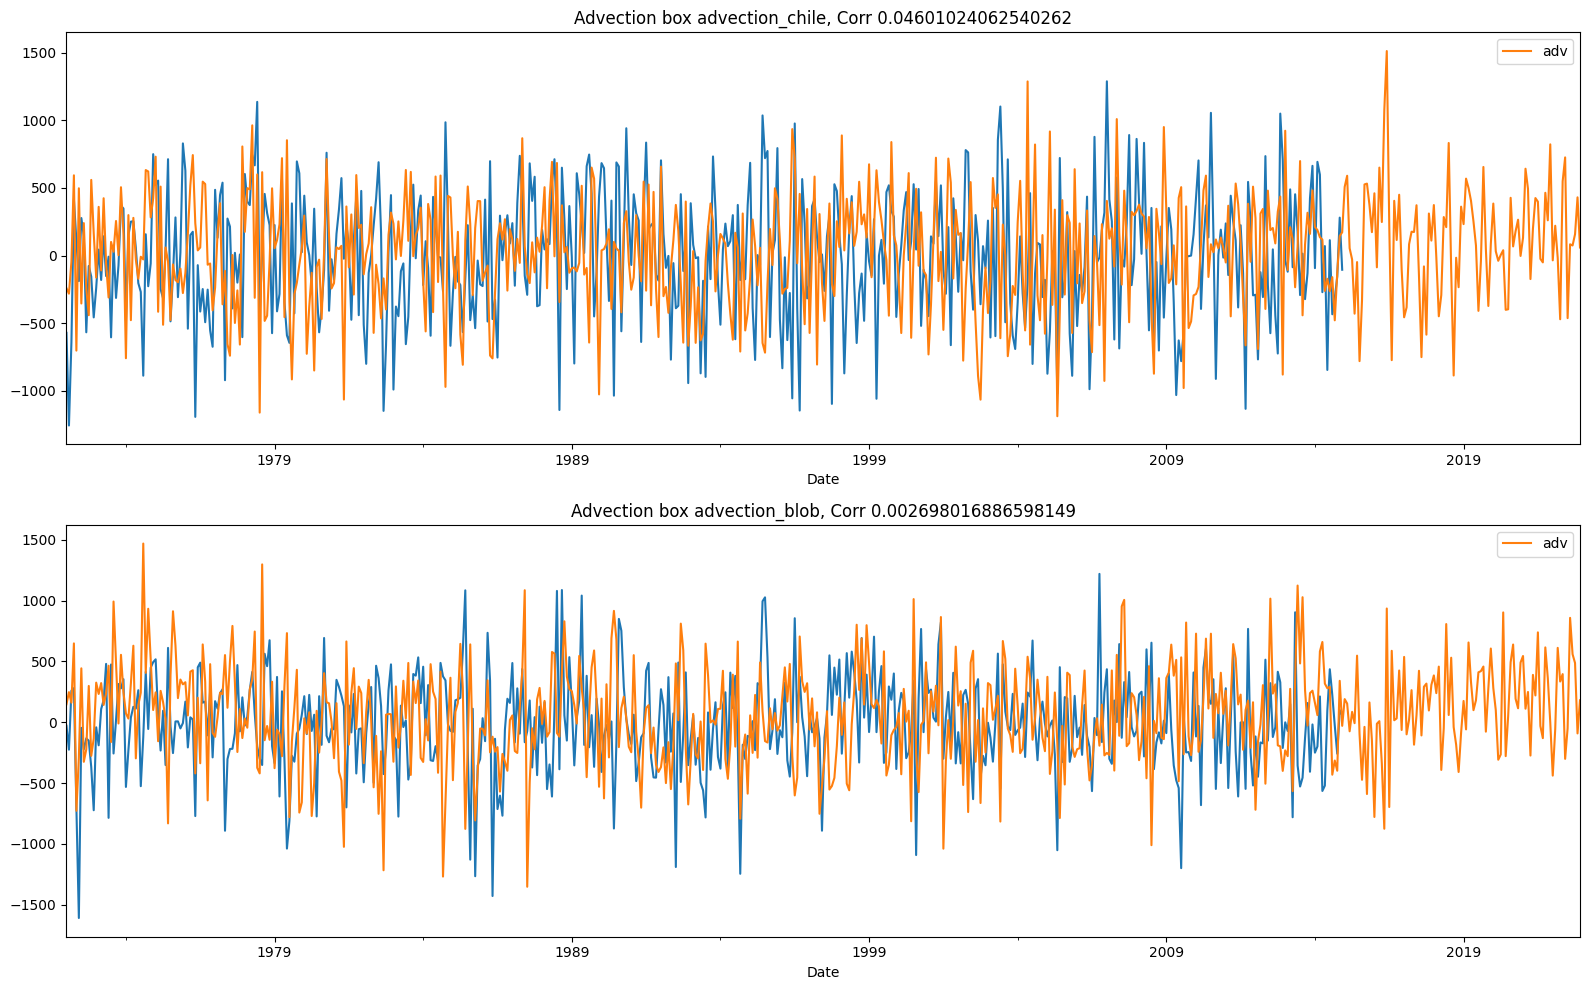

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(16,10))
for i in range(2):
    advection_indices_cmip6[i].get_index("ADV")["adv"].plot(ax=axs[i])
    advection_indices_era5[i].get_index("ADV").plot(ax=axs[i])
    corr = np.corrcoef(advection_indices_cmip6[i].get_index("ADV")["adv"], advection_indices_era5[i].get_index("ADV", end_year=2014)["adv"])[0,1]
    axs[i].set_title(f"Advection box {list(boxes_chile_adv.keys())[i]}, Corr {corr}")
fig.tight_layout()
plt.show()

Here we can see matching patterns aswell, specially for the advection_blob box (which again, is larger than the advection_chile box). Again specially from 2000. 

## Wind features

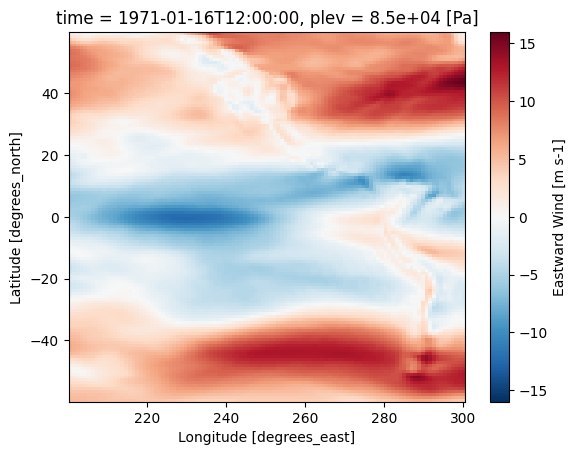

In [26]:
ua.sel(latitude=slice(-60,60), longitude=slice(200,300), plev=85000).isel(time=0).ua.plot()

In [27]:
boxes_chile_winds = {
    "chile_u_norte": [287.5, 289.5, -37, -33],
    "chile_u_sur": [286.5, 288.5, -42, -37],
    "A_arg": [286, 292, -52, -40]
}
chile_wind_cmip6 = ua.sel(latitude=slice(boxes_chile_winds["chile_u_norte"][2], boxes_chile_winds["chile_u_norte"][3]),
                           longitude=slice(boxes_chile_winds["chile_u_norte"][0], boxes_chile_winds["chile_u_norte"][1]), 
                           plev=85000).ua.mean(dim=["latitude","longitude"]
                           )
chile_wind_era5 = data_850.sel(latitude=slice(boxes_chile_winds["chile_u_norte"][2], boxes_chile_winds["chile_u_norte"][3]),
                           longitude=slice(boxes_chile_winds["chile_u_norte"][0], boxes_chile_winds["chile_u_norte"][1])
                           ).u.mean(dim=["latitude","longitude"])

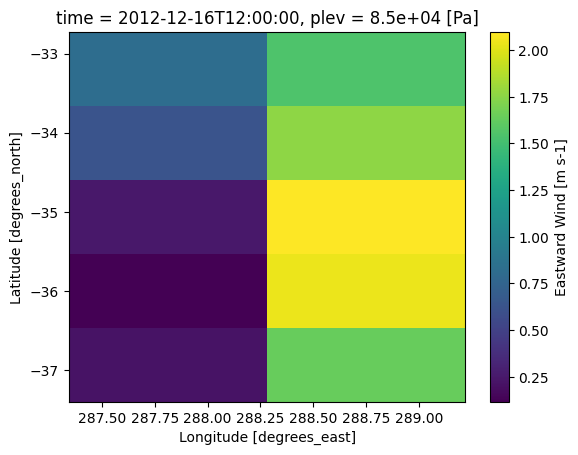

In [28]:
ua.sel(latitude=slice(boxes_chile_winds["chile_u_norte"][2], boxes_chile_winds["chile_u_norte"][3]),
                           longitude=slice(boxes_chile_winds["chile_u_norte"][0], boxes_chile_winds["chile_u_norte"][1]), 
                           plev=85000,time="2012-12").ua.plot()

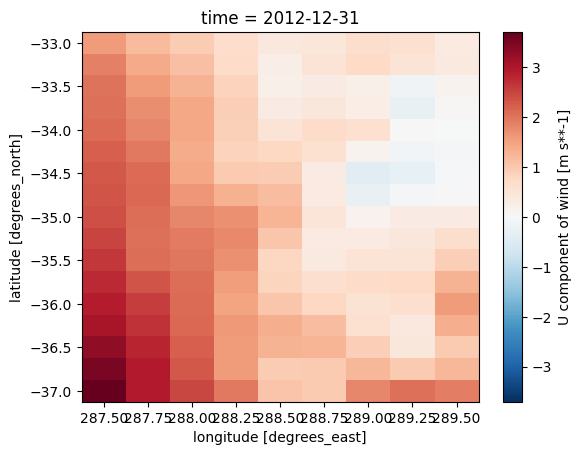

In [29]:
data_850.sel(latitude=slice(boxes_chile_winds["chile_u_norte"][2], boxes_chile_winds["chile_u_norte"][3]),
                           longitude=slice(boxes_chile_winds["chile_u_norte"][0], boxes_chile_winds["chile_u_norte"][1])
                           ,time="2012-12").u.plot()

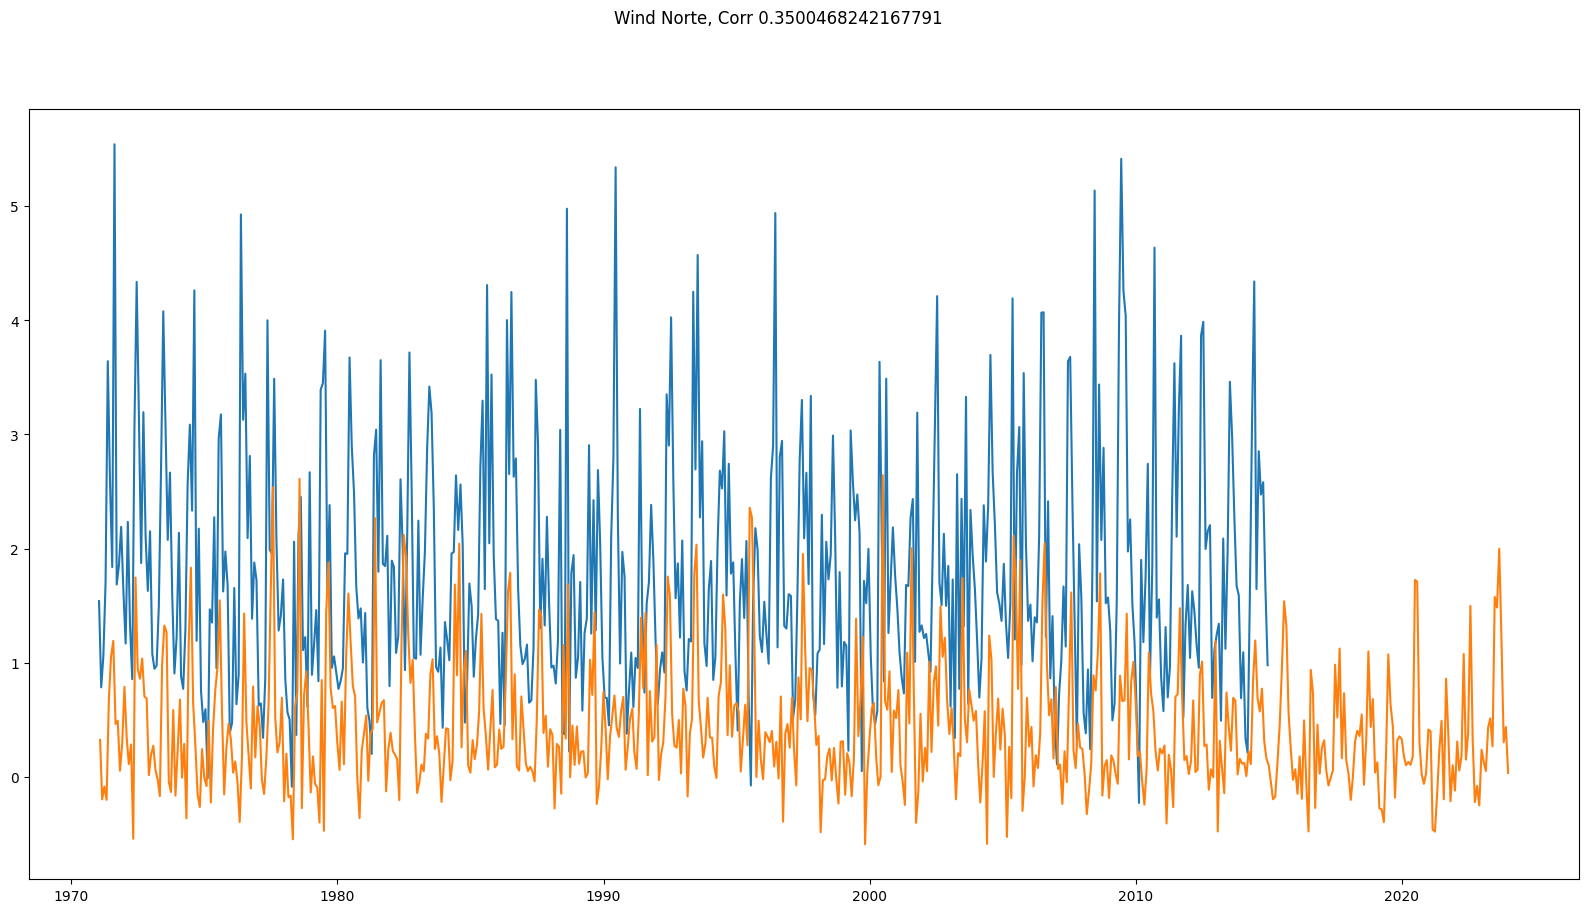

In [30]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(ua.time, chile_wind_cmip6)
ax.plot(data_850.time, chile_wind_era5)
corr = np.corrcoef(chile_wind_cmip6, chile_wind_era5[:528])[0,1]
fig.suptitle(f"Wind Norte, Corr {corr}")
plt.show()

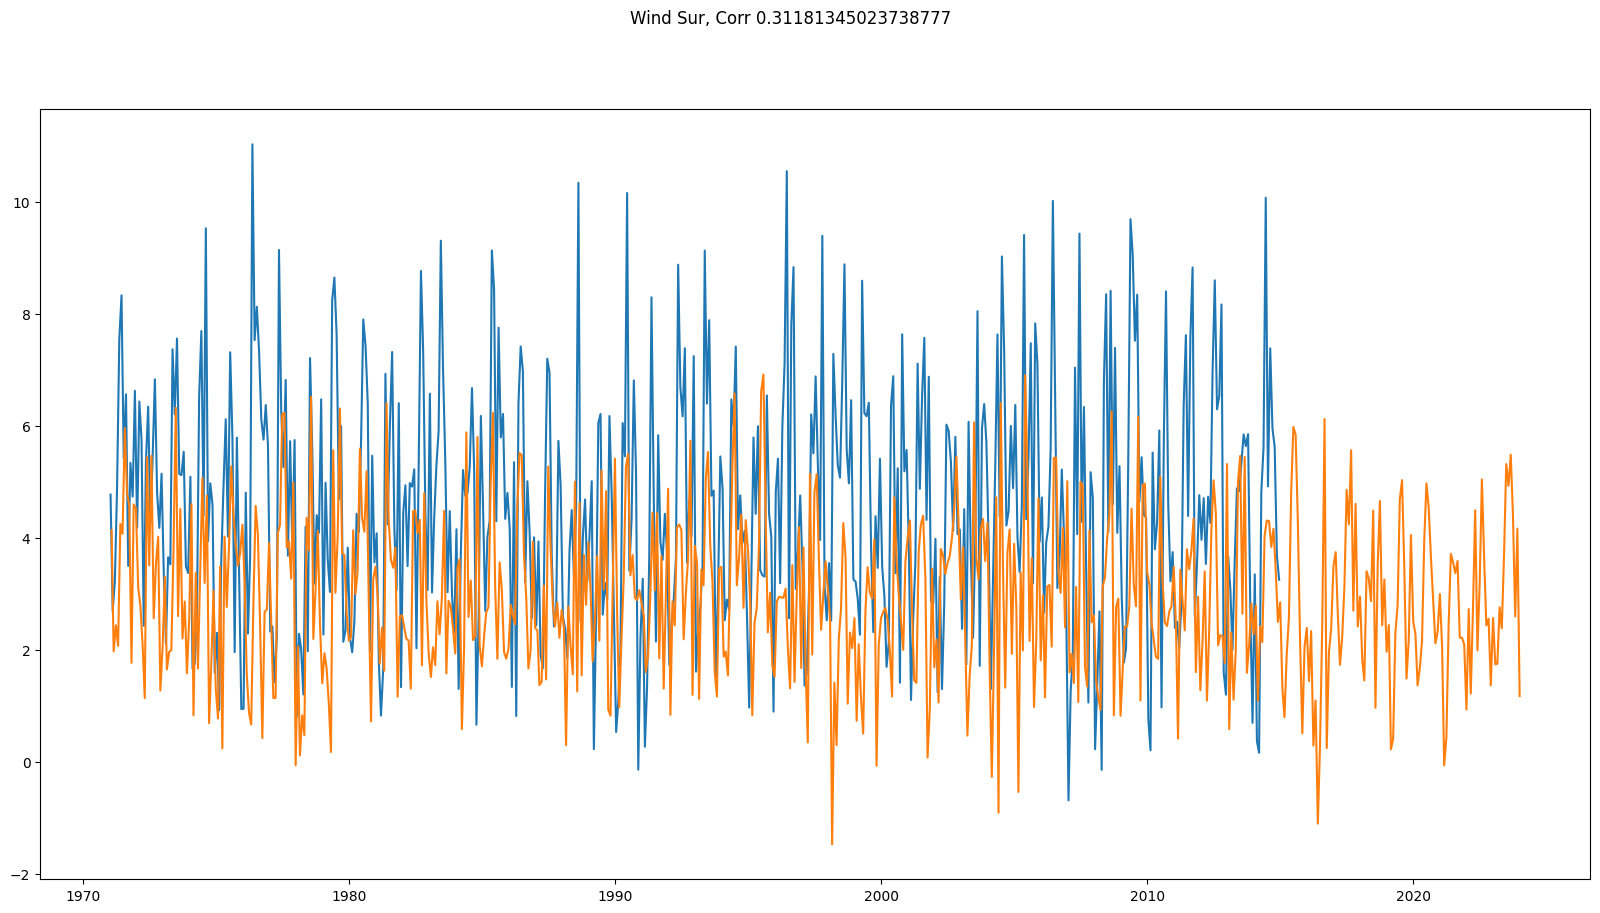

In [31]:
chile_wind_cmip6 = ua.sel(latitude=slice(boxes_chile_winds["chile_u_sur"][2], boxes_chile_winds["chile_u_sur"][3]),
                           longitude=slice(boxes_chile_winds["chile_u_sur"][0], boxes_chile_winds["chile_u_sur"][1]), 
                           plev=85000).ua.mean(dim=["latitude","longitude"]
                           )
chile_wind_era5 = data_850.sel(latitude=slice(boxes_chile_winds["chile_u_sur"][2], boxes_chile_winds["chile_u_sur"][3]),
                           longitude=slice(boxes_chile_winds["chile_u_sur"][0], boxes_chile_winds["chile_u_sur"][1])
                           ).u.mean(dim=["latitude","longitude"])
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(ua.time, chile_wind_cmip6)
ax.plot(data_850.time, chile_wind_era5)
corr = np.corrcoef(chile_wind_cmip6, chile_wind_era5[:528])[0,1]
fig.suptitle(f"Wind Sur, Corr {corr}")
plt.show()

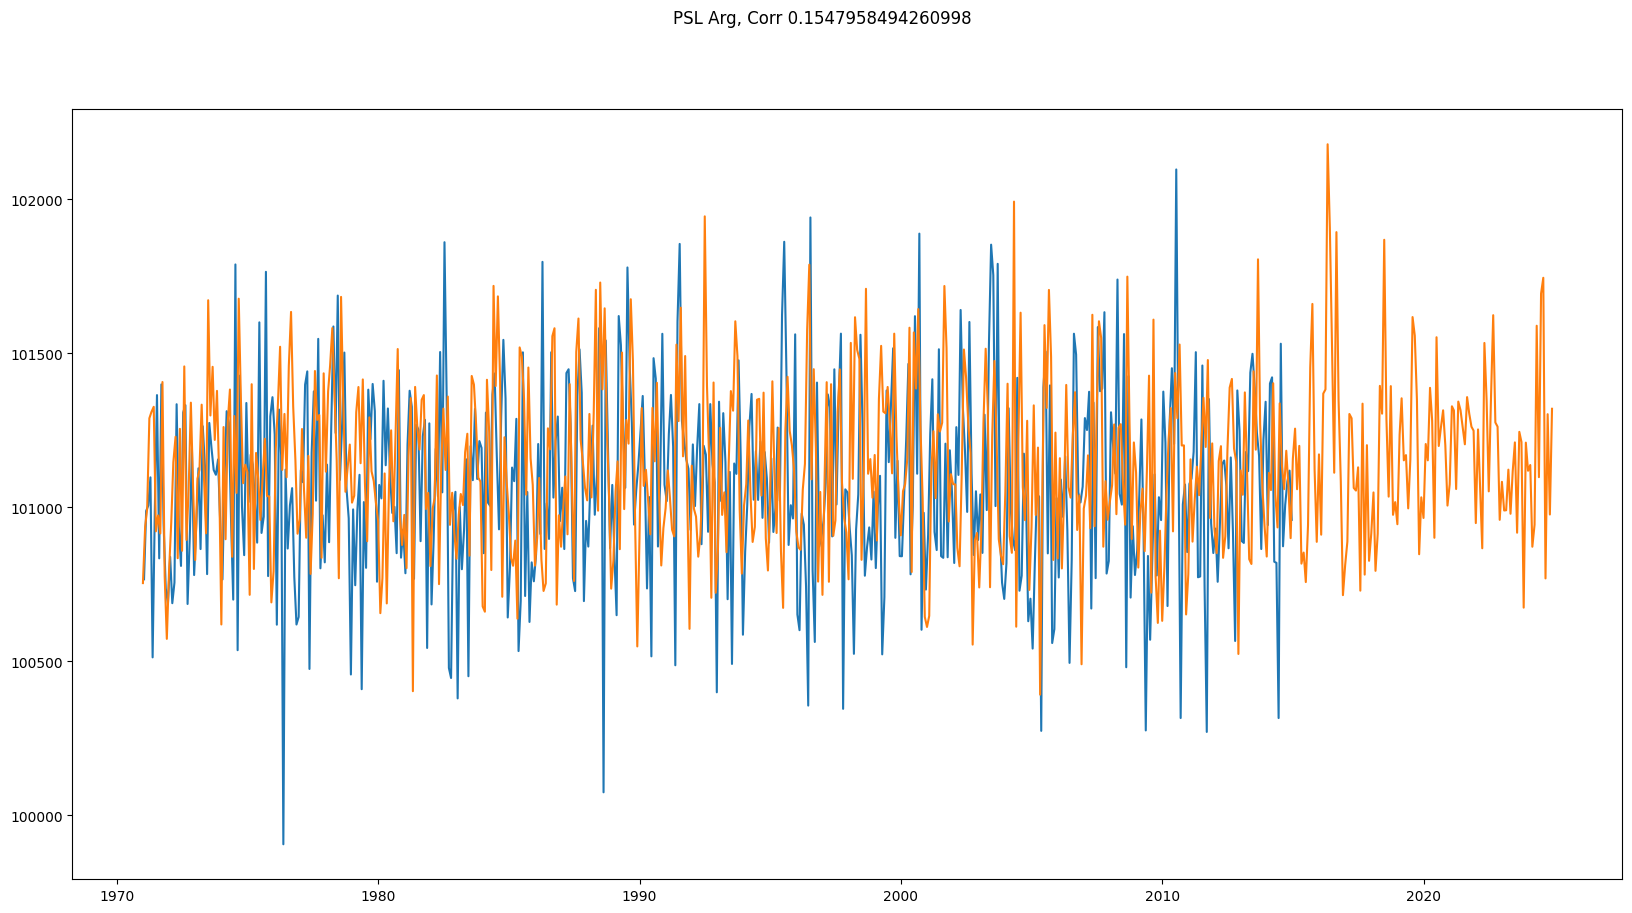

In [32]:
chile_msl_cmip6 = psl.sel(latitude=slice(boxes_chile_winds["A_arg"][2], boxes_chile_winds["A_arg"][3]),
                           longitude=slice(boxes_chile_winds["A_arg"][0], boxes_chile_winds["A_arg"][1])
                            ).psl.mean(dim=["latitude","longitude"]
                           )
chile_msl_era5 = data_msl.sel(latitude=slice(boxes_chile_winds["A_arg"][2], boxes_chile_winds["A_arg"][3]),
                           longitude=slice(boxes_chile_winds["A_arg"][0], boxes_chile_winds["A_arg"][1])
                           ).msl.mean(dim=["latitude","longitude"])
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(ua.time, chile_msl_cmip6)
ax.plot(data_msl.time, chile_msl_era5)
corr = np.corrcoef(chile_msl_cmip6, chile_msl_era5[:528])[0,1]
fig.suptitle(f"PSL Arg, Corr {corr}")
plt.show()

First index that is really different, even tho correlation looks good (reproduce the variability), the values are so different. The wind south box is a bit larger than the north one, maybe thats the reason (again to neglate resolution difference). 

Pressure box looks as good as the other indices (match some peaks and valleys and variability looks similar).

As conclusion, the drivers (except winds) are correctly reproduced in CMIP6 in the sense of frequency and intensity. It is known that they do not reproduce the exact date of the phenomena, but rather its phase and amplitude. With this knowledge, it is arguably valid to run the ERA5-trained model on this data. We would not reproduce (or we do not care) about the date where the HWs are being predicted, but rather an yearly/decadal statistic over the scenarios. As the drivers are well reproduced in the sense of phase and amplitude, then a long year statistic would neglate the effect of "when" is predicted (as the machine is monthly).

## FFT of drivers

In [13]:
def compute_fft(pc, sampling_interval):
    fft_result = np.fft.fft(pc)    
    freqs = np.fft.fftfreq(len(pc), d=sampling_interval)
    magnitude = np.abs(fft_result)
    
    return freqs, magnitude

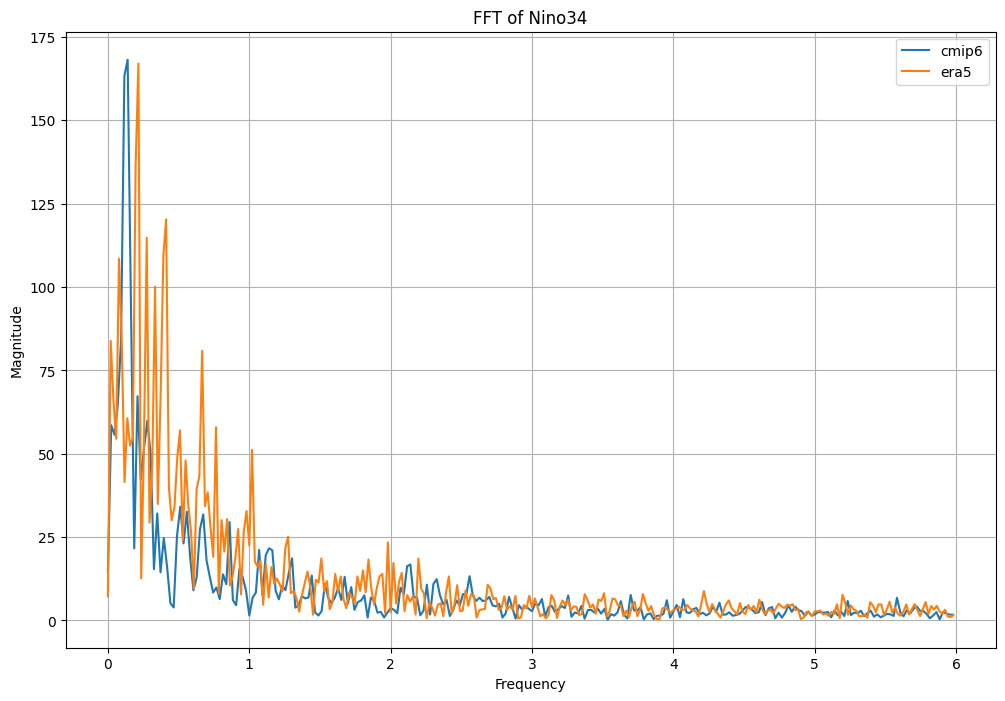

In [30]:
freqs_cmip6, magnitudes_cmip6 = compute_fft(nino34_cmip6.get_index("tos")["tos"].to_numpy(), 1/12)
freqs_era5, magnitudes_era5 = compute_fft(nino34_era5.get_index("SST")["sst"].to_numpy(), 1/12)


# Plot the FFT result
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(freqs_cmip6[:len(freqs_cmip6)//2], magnitudes_cmip6[:len(magnitudes_cmip6)//2], label="cmip6")
ax.plot(freqs_era5[:len(freqs_era5)//2], magnitudes_era5[:len(magnitudes_era5)//2], label="era5")
plt.title('FFT of Nino34')
plt.xlabel('Frequency')
plt.legend()
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

In [32]:
top_3_indices = np.argsort(magnitudes_era5[:len(magnitudes_era5)//2].flatten())[-4:]  
top_3_indices = top_3_indices[np.argsort(magnitudes_era5[:len(magnitudes_era5)//2][top_3_indices])[::-1]]

top_3_frequencies = freqs_era5[top_3_indices]
top_3_magnitudes = magnitudes_era5[:len(magnitudes_era5)//2][top_3_indices]

for i in range(4):  
    print(f"Peak {i+1}: Frequency = {top_3_frequencies[i]}, Wavelength (Years) = {1/top_3_frequencies[i]}, Magnitude = {top_3_magnitudes[i]}")


Peak 1: Frequency = 0.21568627450980393, Wavelength (Years) = 4.636363636363636, Magnitude = 167.04449570074308
Peak 2: Frequency = 0.19607843137254902, Wavelength (Years) = 5.1, Magnitude = 136.69966092504282
Peak 3: Frequency = 0.4117647058823529, Wavelength (Years) = 2.428571428571429, Magnitude = 120.30804057504491
Peak 4: Frequency = 0.27450980392156865, Wavelength (Years) = 3.6428571428571423, Magnitude = 114.81758856076259


In [33]:
top_3_indices = np.argsort(magnitudes_cmip6[:len(magnitudes_cmip6)//2].flatten())[-4:]  
top_3_indices = top_3_indices[np.argsort(magnitudes_cmip6[:len(magnitudes_cmip6)//2][top_3_indices])[::-1]]

top_3_frequencies = freqs_era5[top_3_indices]
top_3_magnitudes = magnitudes_cmip6[:len(magnitudes_cmip6)//2][top_3_indices]

for i in range(4):  
    print(f"Peak {i+1}: Frequency = {top_3_frequencies[i]}, Wavelength (Years) = {1/top_3_frequencies[i]}, Magnitude = {top_3_magnitudes[i]}")


Peak 1: Frequency = 0.11764705882352941, Wavelength (Years) = 8.5, Magnitude = 168.18479861446292
Peak 2: Frequency = 0.09803921568627451, Wavelength (Years) = 10.2, Magnitude = 163.3126116362904
Peak 3: Frequency = 0.13725490196078433, Wavelength (Years) = 7.285714285714285, Magnitude = 95.51232974911095
Peak 4: Frequency = 0.0784313725490196, Wavelength (Years) = 12.75, Magnitude = 84.28773579804685


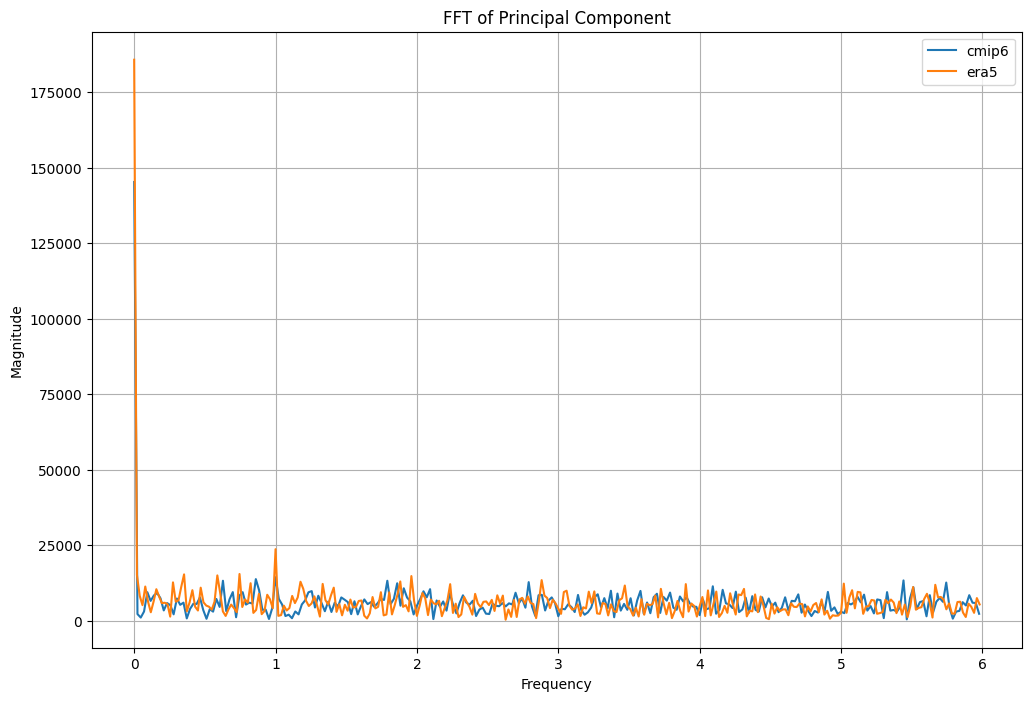

In [35]:
freqs_cmip6, magnitudes_cmip6 = compute_fft(ocean_cyclone_cmip6.get_index("psl")["max_value"].to_numpy(), 1/12)
freqs_era5, magnitudes_era5 = compute_fft(ocean_cyclone_era5.get_index("MSL")["max_value"].to_numpy(), 1/12)


# Plot the FFT result
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(freqs_cmip6[:len(freqs_cmip6)//2], magnitudes_cmip6[:len(magnitudes_cmip6)//2], label="cmip6")
ax.plot(freqs_era5[:len(freqs_era5)//2], magnitudes_era5[:len(magnitudes_era5)//2], label="era5")
plt.title('FFT of Principal Component')
plt.xlabel('Frequency')
plt.legend()
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()